In [ ]:
'''
=====================================================
🔹 Steps for ResNet (Transfer Learning)
=====================================================

1. Dataset Preparation
   - Load IQ-OTHNCCD lung cancer dataset
   - Convert images to grayscale (single channel) or adapt to 3 channels
   - Resize to 128x128 or 224x224 (standard for ResNet)
   - Normalize pixel values
   - Split into training and validation sets

2. Dataset & DataLoader
   - Use PyTorch Dataset + DataLoader
   - Apply data augmentation (flips, rotations, random crops)

3. Load Pretrained ResNet Model
   - Import ResNet18 (or ResNet50) from torchvision.models
   - Modify the first convolution layer for grayscale input
   - Replace the final fully connected (fc) layer with 3 outputs (Normal, Benign, Malignant)

4. Training Loop
   - Use Adam optimizer with learning rate scheduling
   - Compute CrossEntropyLoss
   - Backpropagate and update model weights

5. Validation
   - Evaluate after each epoch
   - Track validation accuracy and loss

6. Evaluation
   - Confusion matrix
   - Classification report (precision, recall, F1-score)

7. Visualization
   - Training vs validation accuracy/loss curves
   - Grad-CAM heatmaps to visualize what part of the lung image the model focuses on

8. Save Model
   - Save the trained ResNet weights (.pth file)


'''


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [3]:
# Change this to your dataset path
!pip install kagglehub

import kagglehub, os

# Download IQ-OTHNCCD Lung Cancer Dataset
path = kagglehub.dataset_download("adityamahimkar/iqothnccd-lung-cancer-dataset")
print("Dataset downloaded to:", path)

# Define dataset paths
DATA_DIR = os.path.join(path, "The IQ-OTHNCCD lung cancer dataset", "The IQ-OTHNCCD lung cancer dataset")
OUT_DIR = "data/processed_rf"
os.makedirs(OUT_DIR, exist_ok=True)

print("DATA_DIR:", DATA_DIR)
print("OUT_DIR:", OUT_DIR)


label_map = {
    "Normal cases": 0,
    "Bengin cases": 1,
    "Malignant cases": 2
}

IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 10
device = "cuda" if torch.cuda.is_available() else "cpu"


In [5]:
all_data = []
for cls, label in label_map.items():
    folder = os.path.join(DATA_DIR, cls)
    for fname in tqdm(os.listdir(folder), desc=cls):
        if fname.lower().endswith(".jpg"):
            path = os.path.join(folder, fname)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img.astype(np.float32) / 255.0
            save_name = f"{cls}_{fname.replace(' ','_')}.npz"
            np.savez_compressed(os.path.join(OUT_DIR, save_name),
                                image=img, label=label)
            all_data.append([save_name, label])

df = pd.DataFrame(all_data, columns=["file","label"])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

train_df = df.sample(frac=0.8, random_state=42)
val_df = df.drop(train_df.index)

train_df.to_csv(os.path.join(OUT_DIR,"train.csv"), index=False)
val_df.to_csv(os.path.join(OUT_DIR,"val.csv"), index=False)

print("Train size:", len(train_df), "Val size:", len(val_df))


Malignant cases: 100%|███████████████████████| 561/561 [00:02<00:00, 242.08it/s]

Train size: 878 Val size: 219


In [7]:
class LungCancerDataset(Dataset):
    def __init__(self, csv_file, root_dir="data/processed", augment=False):
        self.df = pd.read_csv(csv_file)
        self.root = root_dir
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        data = np.load(os.path.join(self.root, row['file']))
        x = np.expand_dims(data['image'], axis=0).astype(np.float32)
        y = int(data['label'])

        if self.augment:
            if np.random.rand() < 0.5: x = np.flip(x, axis=1).copy()
            if np.random.rand() < 0.5: x = np.flip(x, axis=2).copy()

        return torch.tensor(x), torch.tensor(y, dtype=torch.long)

train_dataset = LungCancerDataset(os.path.join(OUT_DIR,"train.csv"), augment=True)
val_dataset   = LungCancerDataset(os.path.join(OUT_DIR,"val.csv"), augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

x,y = next(iter(train_loader))
print("Batch:", x.shape, "Labels:", y[:10])


Batch: torch.Size([32, 1, 128, 128]) Labels: tensor([2, 0, 2, 2, 2, 0, 0, 0, 1, 0])


In [9]:
def get_resnet18(num_classes=3):
    model = models.resnet18(weights=None)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

model = get_resnet18().to(device)
print(model)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
from torch import optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    # Train
    model.train()
    total_loss, correct, total = 0,0,0
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs,y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()*x.size(0)
        _,preds = outputs.max(1)
        correct += (preds==y).sum().item()
        total += y.size(0)
    train_losses.append(total_loss/total)
    train_accs.append(correct/total)

    # Val
    model.eval()
    total_loss, correct, total = 0,0,0
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs,y)
            total_loss += loss.item()*x.size(0)
            _,preds = outputs.max(1)
            correct += (preds==y).sum().item()
            total += y.size(0)
    val_losses.append(total_loss/total)
    val_accs.append(correct/total)

    print(f"Epoch {epoch+1}/{EPOCHS}: "
          f"Train Acc {train_accs[-1]:.4f}, Val Acc {val_accs[-1]:.4f}")


Epoch 1/10: Train Acc 0.6617, Val Acc 0.5342
Epoch 2/10: Train Acc 0.8998, Val Acc 0.8128
Epoch 3/10: Train Acc 0.9522, Val Acc 0.8858
Epoch 4/10: Train Acc 0.9704, Val Acc 0.8584
Epoch 5/10: Train Acc 0.9818, Val Acc 0.9361
Epoch 6/10: Train Acc 0.9852, Val Acc 0.9361
Epoch 7/10: Train Acc 0.9909, Val Acc 0.9498
Epoch 8/10: Train Acc 0.9886, Val Acc 0.9589
Epoch 9/10: Train Acc 0.9966, Val Acc 0.9680
Epoch 10/10: Train Acc 0.9989, Val Acc 0.9635


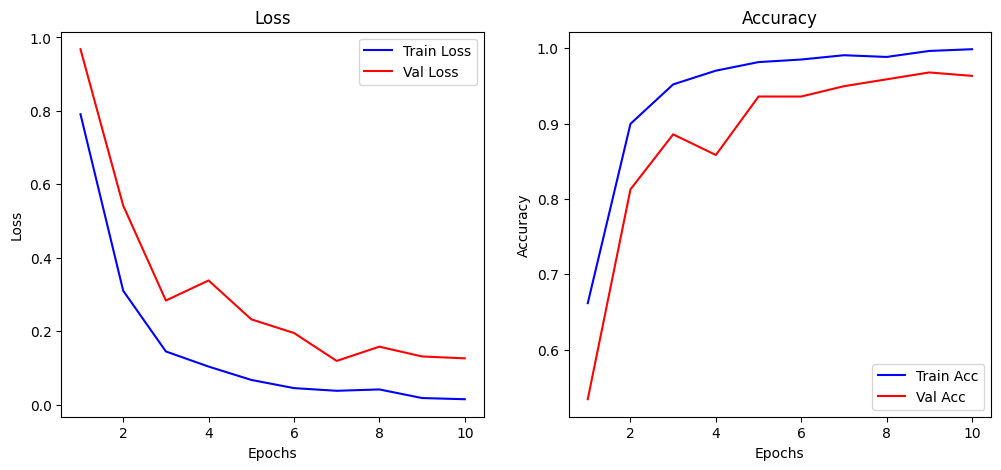

In [12]:
epochs = range(1,EPOCHS+1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, 'b-', label="Train Loss")
plt.plot(epochs, val_losses, 'r-', label="Val Loss")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(epochs, train_accs, 'b-', label="Train Acc")
plt.plot(epochs, val_accs, 'r-', label="Val Acc")
plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy")

plt.show()


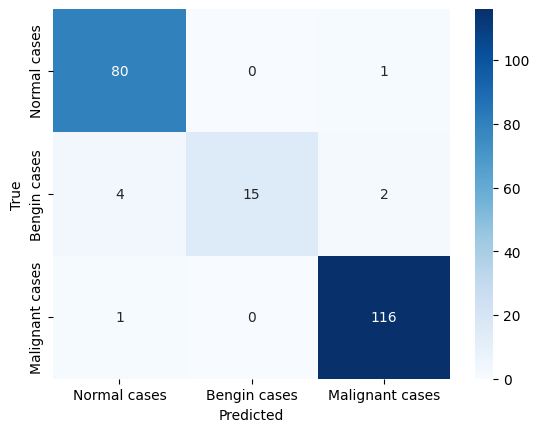

                 precision    recall  f1-score   support

   Normal cases       0.94      0.99      0.96        81
   Bengin cases       1.00      0.71      0.83        21
Malignant cases       0.97      0.99      0.98       117

       accuracy                           0.96       219
      macro avg       0.97      0.90      0.93       219
   weighted avg       0.96      0.96      0.96       219



In [13]:
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for x,y in val_loader:
        x,y = x.to(device), y.to(device)
        preds = model(x).argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(label_map.keys()),
            yticklabels=list(label_map.keys()))
plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

print(classification_report(all_labels, all_preds,
                            target_names=list(label_map.keys())))


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


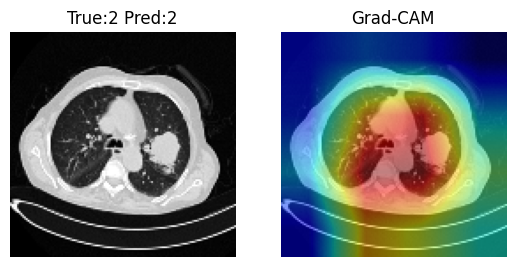

In [14]:
target_layer = model.layer4[1].conv2
activations, gradients = {}, {}

def forward_hook(module, input, output): activations['value'] = output.detach()
def backward_hook(module, grad_in, grad_out): gradients['value'] = grad_out[0].detach()
h1 = target_layer.register_forward_hook(forward_hook)
h2 = target_layer.register_backward_hook(backward_hook)

def gradcam(img_tensor, label=None):
    output = model(img_tensor)
    if label is None:
        label = output.argmax(dim=1).item()
    loss = output[:, label]
    model.zero_grad()
    loss.backward()
    act = activations['value']; grad = gradients['value']
    weights = grad.mean(dim=(2,3), keepdim=True)
    cam = (weights*act).sum(dim=1, keepdim=True)
    cam = F.relu(cam)
    cam = F.interpolate(cam, size=(128,128), mode='bilinear', align_corners=False)
    cam = cam.squeeze().cpu().numpy()
    cam = (cam-cam.min())/(cam.max()-cam.min()+1e-8)
    return cam, label

# Test Grad-CAM on one sample
x,y = next(iter(val_loader))
x_img, true_label = x[0].unsqueeze(0).to(device), y[0].item()
cam, pred = gradcam(x_img)

plt.subplot(1,2,1)
plt.imshow(x_img.squeeze().cpu().numpy(), cmap="gray")
plt.title(f"True:{true_label} Pred:{pred}"); plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(x_img.squeeze().cpu().numpy(), cmap="gray")
plt.imshow(cam, cmap="jet", alpha=0.5)
plt.title("Grad-CAM"); plt.axis("off")
plt.show()

h1.remove(); h2.remove()


In [15]:
torch.save(model.state_dict(), "lung_resnet18.pth")
print("Model saved!")


Model saved!


In [ ]:
'''
=====================================================
🔹 Comparison of Models for Lung Cancer Classification
=====================================================

1. Random Forest (Classical ML)
-----------------------------------------------------
- Input: Flattened grayscale images (e.g., 64x64 → 4096 features)
- Feature Learning: No automatic feature learning → model sees raw pixel values
- Training Time: Fast (on CPU)
- Accuracy: Moderate (depends on image quality and preprocessing)
- Pros:
  * Simple and easy to train
  * Works well on small datasets
  * No need for GPU
- Cons:
  * Cannot capture spatial image patterns well
  * Limited accuracy compared to deep learning

2. Custom CNN (Deep Learning from Scratch)
-----------------------------------------------------
- Input: Grayscale images (e.g., 128x128)
- Feature Learning: Learns filters automatically (edges, textures, shapes)
- Training Time: Moderate (needs GPU for faster training)
- Accuracy: Better than Random Forest if dataset is large enough
- Pros:
  * Learns useful image features directly
  * End-to-end pipeline (raw image → classification)
  * Flexible and customizable
- Cons:
  * Needs more data than Random Forest
  * Risk of overfitting if dataset is small
  * Training is slower than Random Forest

3. ResNet (Transfer Learning with Pretrained Model)
-----------------------------------------------------
- Input: Resized images (128x128 or 224x224)
- Feature Learning: Uses pretrained convolutional layers (from ImageNet)
- Training Time: Longer per epoch, but fewer epochs needed
- Accuracy: Highest among the three (best generalization)
- Pros:
  * Pretrained weights → works even on small datasets
  * Residual connections → stable training for deep networks
  * Usually state-of-the-art accuracy
- Cons:
  * Requires GPU and more compute resources
  * Model size is larger (more parameters)

=====================================================
🔹 Summary
-----------------------------------------------------
- Random Forest → Fast, simple, good baseline
- Custom CNN   → Learns features from scratch, better than RF if enough data
- ResNet       → Most powerful, best accuracy, benefits from transfer learning
=====================================================
'''
